In [1]:
import os
import numpy as np
import cv2
import glob
import itertools
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from shutil import copy, copyfile
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import LoadImages

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
test_images_path = "./data/test/"
test_segs_path = "./data/testpredictions/"
test_batch_size = 1

train_images_path = "./data/train/"
train_segs_path = "./data/trainmask/"
train_batch_size = 6
n_classes = 2  #7
#n_classes = 4

#input_height = 360
#input_width = 480
input_height = 224
input_width = 224
save_weights_path = "./weights/"
epochs = 10 #600
load_weights = ""
load_weights = "weights/VGGUnet.weights.best.hdf5"
checkpoint_filepath = "weights/VGGUnet.weights.best.hdf5"

val_images_path = "./data/val/"
val_segs_path = "./data/valmask/"
val_batch_size = 6

output_path = "./data/augmented/"

**Load data using LoadImages module **

In [3]:
output_width = 224
output_height = 224

In [4]:
X_train, y_train = LoadImages.imageSegmentationArray(train_images_path, train_segs_path,
                                                     train_batch_size, n_classes,
                                                     input_height, input_width, 
                                                     output_height, output_width)
X_train.shape, y_train.shape

((78, 3, 224, 224), (78, 224, 224, 2))

In [5]:
IMAGE_ORDERING = 'channels_first'

In [6]:
def show_original(img):
    img = np.rollaxis(img, 0, 3)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img.astype(np.int32)
    plt.imshow(img)

** Load data manually **

In [7]:
images = glob.glob(train_images_path + "*.png")
images.sort()
segmentations = glob.glob(train_segs_path + "*.png")
segmentations.sort()
assert len(images) == len(segmentations)

In [8]:
X_train = []
y_train = []

for img, seg in zip(images, segmentations):
    assert (img.split('/')[-1].split(".")[0] == 
            seg.split('/')[-1].split(".")[0])
    
    X_train.append(cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    y_train.append(cv2.imread(seg, cv2.IMREAD_UNCHANGED))
    
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((78, 482, 482, 3), (78, 482, 482, 3))

In [9]:
IMAGE_ORDERING = 'channels_last'

** Transformations applied to one image **

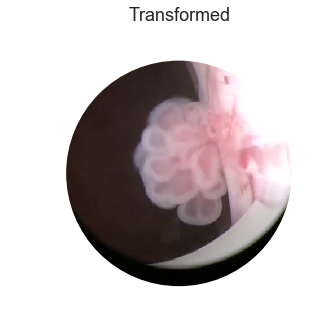

In [10]:
# number of generated images
count = 0

# create data generator
datagen = ImageDataGenerator(
#     rotation_range=-180,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
    vertical_flip=True,
#     brightness_range=[1.0,2.0],
#     zoom_range=[0.5,1.0],
#     data_format=IMAGE_ORDERING
)

# load image to array: v1s07651.png
img = X_train[59].copy()

# fig, ax = plt.subplots(figsize=(5, 5))

# patch = patches.Circle((240, 210), radius=200, transform=ax.transData)
# im1 = ax.imshow(img);
# im1.set_clip_path(patch)
# plt.axis("off");
# plt.title("Original");
# plt.savefig('../../materials/figures/aug_original.png', bbox_inches='tight', dpi=300);


img = img.reshape((1,) + img.shape)
images_flow = datagen.flow(img, batch_size=1)

for i, new_images in enumerate(images_flow):
    new_image = array_to_img(new_images[0], scale=True)
    fig, ax = plt.subplots(figsize=(5, 5))

    patch = patches.Circle((240, 260), radius=200, transform=ax.transData)
    im1 = ax.imshow(new_image);
    im1.set_clip_path(patch)
    plt.axis("off");
    plt.title("Transformed");
    plt.savefig('../../materials/figures/aug_vertical.png', bbox_inches='tight', dpi=300);
#     plt.figure();
#     plt.imshow(new_image);
#     show_original(new_images[0])
#     new_image.save(output_path.format(i + 1))
    if i >= count:
        break

** Transformations applied to one image and its mask **

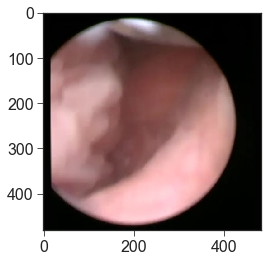

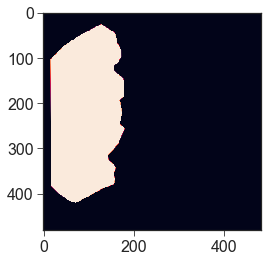

In [12]:
seed = 42
rotation_range = 360

image_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                   horizontal_flip=True,
                                   vertical_flip=True, 
                                   data_format=IMAGE_ORDERING)

mask_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                  horizontal_flip=True,
                                  vertical_flip=True)

# # load image to array
img = X_train[0].copy()
seg = y_train[0].copy()

# # reshape to array rank 4
img = img.reshape((1,) + img.shape)
seg = seg.reshape((1,) + seg.shape)

# # # let's create infinite flow of images
images_flow = image_datagen.flow(img, batch_size=1, seed=seed)
segs_flow = mask_datagen.flow(seg, batch_size=1, seed=seed)


for i, new_images in enumerate(images_flow):
    # we access only first image because of batch_size=1
    new_image = array_to_img(new_images[0], scale=True)
    plt.figure();
    plt.imshow(new_image);
#     show_original(new_images[0])
#     new_image.save(output_path.format(i + 1))
    if i >= count:
        break
        
for i, new_images in enumerate(segs_flow):
    # we access only first image because of batch_size=1
#     new_image = array_to_img(new_images[0], scale=True)
    new_image = new_images[0, :, :, 1]
    plt.figure();
    plt.imshow(new_image);
#     new_image.save(output_path.format(i + 1))
    if i >= count:
        break

** Transformations applied to images and their masks from arrays **

In [18]:
seed = 42
rotation_range = 360

image_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                   horizontal_flip=True,
                                   vertical_flip=True, 
                                   data_format=IMAGE_ORDERING)

mask_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                  horizontal_flip=True,
                                  vertical_flip=True)

image_generator = image_datagen.flow(X_train,
                                     batch_size=train_batch_size, 
                                     seed=seed)

mask_generator = mask_datagen.flow(y_train, 
                                   batch_size=train_batch_size, 
                                   seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.figure();
#         plt.imshow(X_batch[i]);
#         plt.imshow(y_batch[i], alpha=0.5);
#         show_original(X_batch[i])
#         plt.imshow(y_batch[i, :, :, 1], alpha=0.5);
    break

# model.fit_generator(
#     train_generator, 
#     steps_per_epoch=len(X_train) / train_batch_size, 
#     epochs=epochs)
 
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=2000,
#     epochs=50)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
def augmentedDataGenerator(X, y, batch_size):
    seed = 42
    rotation_range = 360

    image_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                       horizontal_flip=True,
                                       vertical_flip=True, 
                                       data_format='channels_first')

    mask_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      data_format='channels_last')

    image_generator = image_datagen.flow(X,
                                         batch_size=batch_size, 
                                         seed=seed)

    mask_generator = mask_datagen.flow(y, 
                                       batch_size=batch_size, 
                                       seed=seed)

    # Combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    
    return train_generator

/Applications/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (78, 482, 482, 3) (482 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


TypeError: Invalid dimensions for image data

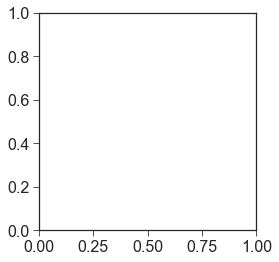

In [20]:
train_generator = augmentedDataGenerator(X_train, y_train, train_batch_size)
for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.figure();
        show_original(X_batch[i])
        plt.imshow(y_batch[i, :, :, 1], alpha=0.5);
    break

TypeError: Invalid dimensions for image data

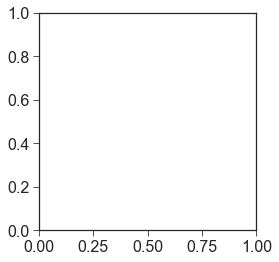

In [21]:
for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.figure();
        show_original(X_batch[i])
        plt.imshow(y_batch[i, :, :, 1], alpha=0.5);
    break

TypeError: Invalid dimensions for image data

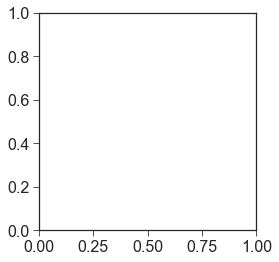

In [22]:
for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.figure();
        show_original(X_batch[i])
        plt.imshow(y_batch[i, :, :, 1], alpha=0.5);
    break

** Transformations applied to images and their masks from directory **

In [23]:
seed = 42
rotation_range = 360

image_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=rotation_range,
                                   horizontal_flip=True,
                                   vertical_flip=True)
mask_datagen = ImageDataGenerator(rotation_range=rotation_range,
                                  horizontal_flip=True,
                                  vertical_flip=True)

image_generator = image_datagen.flow_from_directory(
    directory=folder + images_path,
    batch_size=6,
    class_mode=None,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    directory=folder + segs_path,
    batch_size=6,
    class_mode=None,
    seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

for X_batch, y_batch in train_generator:
    for i in range(0, 6):
        plt.figure();
        plt.imshow(X_batch[i]);
        plt.imshow(y_batch[i], alpha=0.5);
    break

# model.fit_generator(
#     train_generator,
#     steps_per_epoch=2000,
#     epochs=50)

NameError: name 'folder' is not defined